# DQN (Deep Q-Net) using Q-learning using batchnorm- TEST

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [4]:
import gym
import numpy as np

In [5]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [6]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [7]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.04677656 -0.22918207 -0.02811939  0.27293819] 0 1.0 False {}
state, action, reward, done, info
[-0.0513602  -0.03367041 -0.02266062 -0.02847937] 1 1.0 False {}
state, action, reward, done, info
[-0.05203361  0.16176905 -0.02323021 -0.32822496] 1 1.0 False {}
state, action, reward, done, info
[-0.04879823 -0.03301462 -0.02979471 -0.04295736] 0 1.0 False {}
state, action, reward, done, info
[-0.04945852  0.16252163 -0.03065386 -0.3448899 ] 1 1.0 False {}
state, action, reward, done, info
[-0.04620809  0.35806593 -0.03755165 -0.64707937] 1 1.0 False {}
state, action, reward, done, info
[-0.03904677  0.55369041 -0.05049324 -0.95134682] 1 1.0 False {}
state, action, reward, done, info
[-0.02797296  0.74945422 -0.06952018 -1.25945699] 1 1.0 False {}
state, action, reward, done, info
[-0.01298388  0.94539331 -0.09470932 -1.57307813] 1 1.0 False {}
state, action, reward, done, info
[ 0.00592399  1.14150878 -0.12617088 -1.89373592] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [8]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1415087812978828 -1.8937359168548065


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size):
    # Input states/ observation or internal states
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    
    # Output actions
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [10]:
# tf.layers.batch_normalization(
#     inputs, ??????????????????????????????????????
#     axis=-1, okkkkkkkkkkkkkkkkkkkkkkkkkkkk
#     momentum=0.99, okkkkkkkkkkkkkkkkkkkkkkkk
#     epsilon=0.001, okkkkkkkkkkkkkkkkkkkkkkkkkkk
#     center=True, OOOOOOOOOOOOOOOOOOOOOOK
#     scale=True, OOOOOOOOOOOOOOOOOOOOOOOOOOOOOK
#     beta_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOOOOOOOOOOOOOOK
#     gamma_initializer=tf.ones_initializer(), OOOOOOOOOOOOOOOOOOOOOOOOOOOOK
#     moving_mean_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOOOOOOOOOOOK
#     moving_variance_initializer=tf.ones_initializer(), OOOOOOOOOOOOOOOOOOOOOOK
#     beta_regularizer=None,
#     gamma_regularizer=None,
#     beta_constraint=None,
#     gamma_constraint=None,
#     training=False, ??????????????????????????????
#     trainable=True, ???????????????????????????
#     name=None,
#     reuse=None,
#     renorm=False,
#     renorm_clipping=None,
#     renorm_momentum=0.99, OOOOOOOOOOOOOOOOOK
#     fused=None,
#     virtual_batch_size=None,
#     adjustment=None
# )

In [11]:
def generator(states, hidden_size, action_size, reuse=False, is_bn_training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=is_bn_training)
        nl1 = tf.maximum(0.01 * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=is_bn_training)
        nl2 = tf.maximum(0.01 * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)
        # predictions = tf.tanh(logits)

        return logits

In [12]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    actions_labels = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_labels), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return actions_logits, Qs, loss

In [13]:
class DQN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):
        
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
train_episodes = 10          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
learning_rate = 0.001          # learning rate for training/optimization/adam

In [16]:
tf.reset_default_graph()
model = DQN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    # Episode is done/failed or not;
    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from DQN (the inference mode)
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                # actions_logits = sess.run(model.actions_logits, feed_dict)
                model_actions_logits = generator(action_size=action_size, hidden_size=hidden_size, 
                                                 is_bn_training=False, reuse=True, states=model.states)
                actions_logits = sess.run(model_actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Model in the inference mode
            feed_dict={model.states: next_states}
            # next_actions_logits = sess.run(model.actions_logits, feed_dict)
            model_next_actions_logits = generator(action_size=action_size, hidden_size=hidden_size, 
                                             is_bn_training=False, reuse=True, states=model.states)
            next_actions_logits = sess.run(model_next_actions_logits, feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model (the training mode)
            loss, _ = sess.run([model.loss, model.opt],
                                feed_dict={model.states: states,
                                           model.targetQs: targetQs,
                                           model.actions: actions})
            
            # Printing each step before episode is done.
            print('Env/Rob Step: {}'.format(step),
                  'Total reward: {}'.format(total_reward),
                  'Each reward: {}'.format(reward),
                  'Average reward: {}'.format(np.mean(rewards)),
                  'Training loss: {:.4f}'.format(loss),
                  'Explore P: {:.4f}'.format(explore_p))

    # Save the trained model 
    saver.save(sess, "checkpoints/DQN-cartpole.ckpt")

Env/Rob Step: 1 Total reward: 1.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.0778 Explore P: 0.9999
Env/Rob Step: 2 Total reward: 2.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.0559 Explore P: 0.9998
Env/Rob Step: 3 Total reward: 3.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.0937 Explore P: 0.9997
Env/Rob Step: 4 Total reward: 4.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.0635 Explore P: 0.9996
Env/Rob Step: 5 Total reward: 5.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.1184 Explore P: 0.9995
Env/Rob Step: 6 Total reward: 6.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.1082 Explore P: 0.9994
Env/Rob Step: 7 Total reward: 7.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.0558 Explore P: 0.9993
Env/Rob Step: 8 Total reward: 8.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.0872 Explore P: 0.9992
Env/Rob Step: 9 Total reward: 9.0 Each reward: 1.0 Average reward: 1.0 Training loss: 1.1030 Explore P: 0.9991
E

Env/Rob Step: 73 Total reward: 11.0 Each reward: 1.0 Average reward: 1.0 Training loss: 2.4452 Explore P: 0.9928
Env/Rob Step: 74 Total reward: 12.0 Each reward: 1.0 Average reward: 1.0 Training loss: 4.7035 Explore P: 0.9927
Env/Rob Step: 75 Total reward: 13.0 Each reward: 1.0 Average reward: 1.0 Training loss: 2.8388 Explore P: 0.9926
Env/Rob Step: 76 Total reward: 14.0 Each reward: 1.0 Average reward: 1.0 Training loss: 2.3328 Explore P: 0.9925
Env/Rob Step: 77 Total reward: 15.0 Each reward: 1.0 Average reward: 1.0 Training loss: 2.0843 Explore P: 0.9924
Env/Rob Step: 78 Total reward: 16.0 Each reward: 1.0 Average reward: 1.0 Training loss: 2.4596 Explore P: 0.9923
Env/Rob Step: 79 Total reward: 17.0 Each reward: 1.0 Average reward: 1.0 Training loss: 5.3335 Explore P: 0.9922
Env/Rob Step: 80 Total reward: 18.0 Each reward: 1.0 Average reward: 1.0 Training loss: 5.0544 Explore P: 0.9921
Env/Rob Step: 81 Total reward: 19.0 Each reward: 1.0 Average reward: 1.0 Training loss: 6.8592 E

Env/Rob Step: 147 Total reward: 17.0 Each reward: 1.0 Average reward: 1.0 Training loss: 4.0883 Explore P: 0.9856
Env/Rob Step: 148 Total reward: 18.0 Each reward: 1.0 Average reward: 1.0 Training loss: 25.3179 Explore P: 0.9855
Episode: 5 Total reward: 19.0 Training loss: 25.3179 Explore P: 0.9854
Env/Rob Step: 149 Total reward: 19.0 Each reward: 1.0 Average reward: 1.0 Training loss: 4.8036 Explore P: 0.9854
Env/Rob Step: 150 Total reward: 1.0 Each reward: 1.0 Average reward: 1.0 Training loss: 26.2625 Explore P: 0.9853
Env/Rob Step: 151 Total reward: 2.0 Each reward: 1.0 Average reward: 1.0 Training loss: 11.7249 Explore P: 0.9852
Env/Rob Step: 152 Total reward: 3.0 Each reward: 1.0 Average reward: 1.0 Training loss: 2.7366 Explore P: 0.9851
Env/Rob Step: 153 Total reward: 4.0 Each reward: 1.0 Average reward: 1.0 Training loss: 4.7928 Explore P: 0.9850
Env/Rob Step: 154 Total reward: 5.0 Each reward: 1.0 Average reward: 1.0 Training loss: 36.4132 Explore P: 0.9849
Env/Rob Step: 155 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

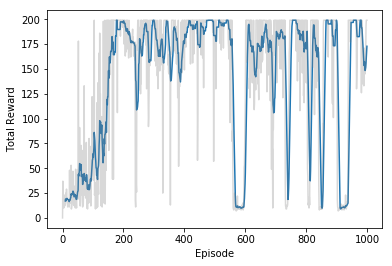

In [17]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0,0.5,'Training Loss')

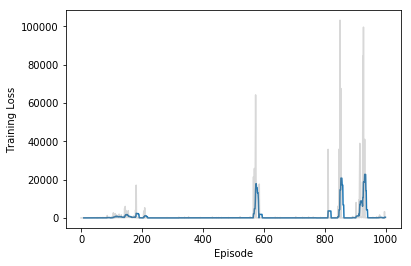

In [18]:
eps, loss = np.array(loss_list).T
smoothed_loss = running_mean(loss, 10)
plt.plot(eps[-len(smoothed_loss):], smoothed_loss)
plt.plot(eps, loss, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Training Loss')

## Testing

Let's checkout how our trained agent plays the game.

In [19]:
test_episodes = 10
test_max_steps = 10000000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Restore/load the trained model 
    saver.restore(sess, "checkpoints/DQN-cartpole.ckpt")
    
    # Training episodes/ epochs
    for ep in range(test_episodes):
        
        # Env/Rob steps for minibatches/batches training
        t = 0
        while t < test_max_steps:
            
            # render the graphics
            env.render() 
            
            # Get action from DQN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # If episode is done/failed;
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

# Closing the simulated env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/DQN-cartpole.ckpt


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.